In [1]:
from fish.ephys.ephys import load, chop_trials, estimate_onset
from fish.util.fileio import read_image
from skimage.transform import resize
from skimage.exposure import rescale_intensity
from skimage.io import imsave
from scipy.io import loadmat
from fish.util.plot import proj_fuse
from glob import glob
import matplotlib.pyplot as plt
plt.style.use('presentation')
%matplotlib inline
import numpy as np

In [2]:
def offset_colorbar(fig, axis, **kwargs):
    from matplotlib.pyplot import colorbar
    pos = axis.get_position()
    b = colorbar(axis.get_images()[0], cax=fig.add_axes([pos.x0 + pos.width, pos.y0, .01, pos.height]), **kwargs)
    b.outline.set_linewidth(0)
    return b    

def stackline(x_axis, array, axis, scale, **kwargs):
    for ind, val in enumerate(array):
        axis.plot(x_axis, val - ind * scale, **kwargs)
    axis.set_xlim(x_axis.min(), x_axis.max())
    
def trigger_data(triggers, window, fnames, average=False, parallelism=None):
    from fish.util.fileio import read_images, read_image    
    from numpy import array, zeros
    
    sample = read_image(fnames[0])

    if average:
        dims = list(sample.shape)
        dims.insert(0, len(window))
        ims_trial = zeros(dims)
    else: 
        dims = list(sample.shape)
        dims.insert(0, len(window))
        dims.insert(0, len(triggers))
        ims_trial = zeros(dims)
    
    for ind, trig in enumerate(triggers):        
        tr = read_images(array(fnames)[trig + window], parallelism)
        
        if average:
            ims_trial += tr.astype('float32')/len(triggers)

        else:
            ims_trial[ind] = tr
    
    return ims_trial

def load_muy_mat(fname, head_name='data'):
    from h5py import File 
    data = {}
    with File(fname) as f: 
        for k in f[head_name].keys():
            data[k] = np.squeeze(f[head_name][k][:])
    return data

def triggered_behavior(triggers, window, swims):
    from numpy import array
    trig_ep = []
    for trig in triggers:
        trig_ep.append(swims[trig + window])
    return array(trig_ep)

def standard_clim(axes, clim_scaling=(1,1)):
    clim = np.array([ax.get_images()[0].get_clim() for ax in axes])
    clim = (clim.min() * clim_scaling[0], clim.max() * clim_scaling[1])
    [ax.get_images()[0].set_clim(clim) for ax in axes]

In [3]:
potential_paths = ['/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170228/fish4/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/',
                   '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170228/fish3/20170228_3_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_165730/',
                  '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170221/fish5/20170221_5_2_gfaprgeco_hucgc_6dpf_wholebrain_20170221_220811/',
                  '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170221/fish5/20170221_5_3_gfaprgeco_hucgc_6dpf_wholebrain_20170221_223941/']

In [4]:
import sys
import json
import pathlib as pl
from os.path import sep

dirs = {}
dirs['base'] = potential_paths[0]
exp_name = dirs['base'].split(sep)[-2]
dirs['ephys'] = dirs['base'] + 'ephys/'
dirs['raw'] = dirs['base'] + 'raw/'
dirs['dff'] = '/groups/ahrens/ahrenslab/davis/tmp/' + exp_name + '/projections/dff/'
dirs['output'] = '/groups/ahrens/ahrenslab/projects/ngm/presentation/resource/'

from fish.image.vol import get_stack_freq
fs_im = get_stack_freq(dirs['raw'])[0]

from fish.image.vol import get_metadata

with open(dirs['dff'] + 'metadata.json', 'r') as f:
    metadata = json.load(f)
dz = get_metadata(dirs['raw'] + '/ch0.xml')['z_step']
um_per_pixel = .40625
dx,dy = (metadata['spatial_downsampling'] * um_per_pixel,) * 2
from functools import reduce
from math import gcd
aspect = (10 * np.array([dz, dy, dx])).astype('int')
aspect = aspect // reduce(gcd, aspect)
fnames = sorted(glob(dirs['dff'] + '*.tif'))

print(len(fnames))

7200


In [5]:
epdat = load_muy_mat(dirs['ephys'] + 'data.mat')
epdat_raw = load_muy_mat(dirs['ephys'] + 'rawdata.mat', head_name='rawdata')
swims = epdat['fltCh1'] + epdat['fltCh2']
cam = np.where(np.diff(epdat['frame']))[0][:len(fnames)]

In [6]:
gu_inds = np.squeeze(loadmat(dirs['ephys'] + 'GU_onset.mat')['trigger_onset'])
frames_gu = epdat['frame'][gu_inds].astype('int')

window_im = np.arange(-10, 11)
keep = np.array([f + window_im[0] > 0 and (f + window_im[-1] < (len(fnames) - 1)) for f in frames_gu])
frames_gu = frames_gu[keep]
print(frames_gu)

[ 478  512  550  598  633  708  758  789 2560 2874 2913 2993 3026 3189 3715
 3769 3876 3915 3972 4015 4069 4122 4169 4219 4271 4321 4367 4422 4469 4514
 4573 4621 4662 4714 4767 4817 4869 4969 5119 5167 5220 5266 5314 5369 5469
 5518 5575 5661 5770 5818 5878 5915 5973 6066 6119 6161 6792 6890 6945 6986
 7042 7087 7140]


In [7]:
%%time
trig_gu = trigger_data(frames_gu, window_im, fnames, average=True, parallelism=10)
in_range = 'uint16'
out_range = tuple(metadata['dff_lims'])
trig_gu = rescale_intensity(trig_gu.astype('float32'), in_range=in_range, out_range=out_range)

CPU times: user 2min 33s, sys: 2min 28s, total: 5min 2s
Wall time: 6min 28s


(-0.5, 1313.5, -0.5, 793.5)

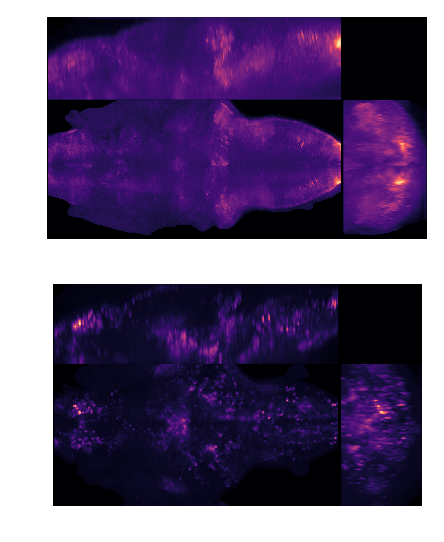

In [8]:
fig, axs = plt.subplots(nrows=2, figsize=(16,9))
from skimage.transform import resize
t = -10
g = proj_fuse(trig_gu[t][:,:(2 * 240)], np.max, aspect=aspect)
n = proj_fuse(trig_gu[t][:,(2 * 240):-40], np.max, aspect=aspect)
axs[0].imshow(g, origin='lower' , cmap='magma')
axs[1].imshow(n, origin='lower', cmap='magma')
axs[0].axis('off')
axs[1].axis('off')

Text(0.5,0,'Time [s]')

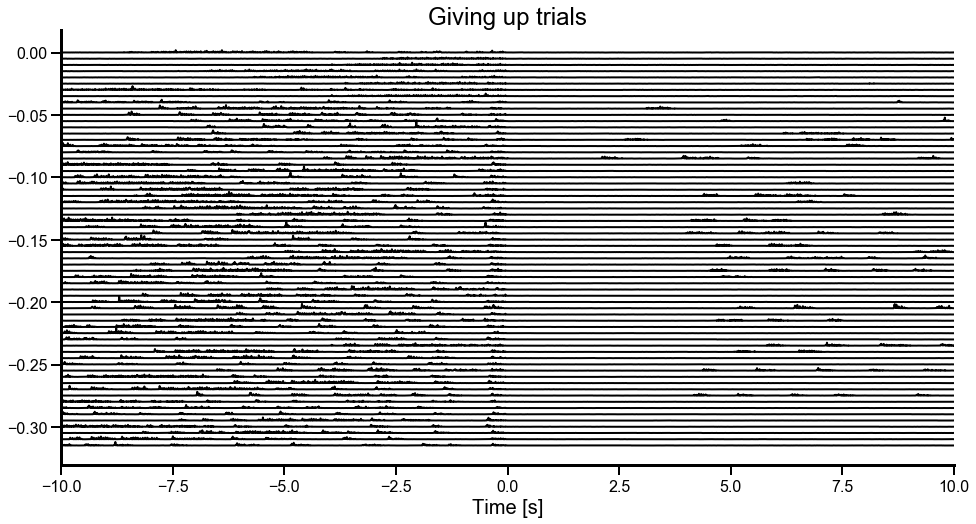

In [9]:
t_points = [10, 20, 30]
fig, axs = plt.subplots(nrows=1, figsize=(16,8), sharex=True)
window = np.arange(-10 * 6000, 10 * 6000)
x_axis_ep = window / 6000

triggers = gu_inds
trig_ep_gu = triggered_behavior(triggers, window, swims)
scale = .005

stackline(x_axis_ep, trig_ep_gu, axis=axs, scale=scale, color='k', linewidth=2)
axs.title.set_text('Giving up trials')
axs.set_xlabel('Time [s]')

In [25]:
np.percentile?

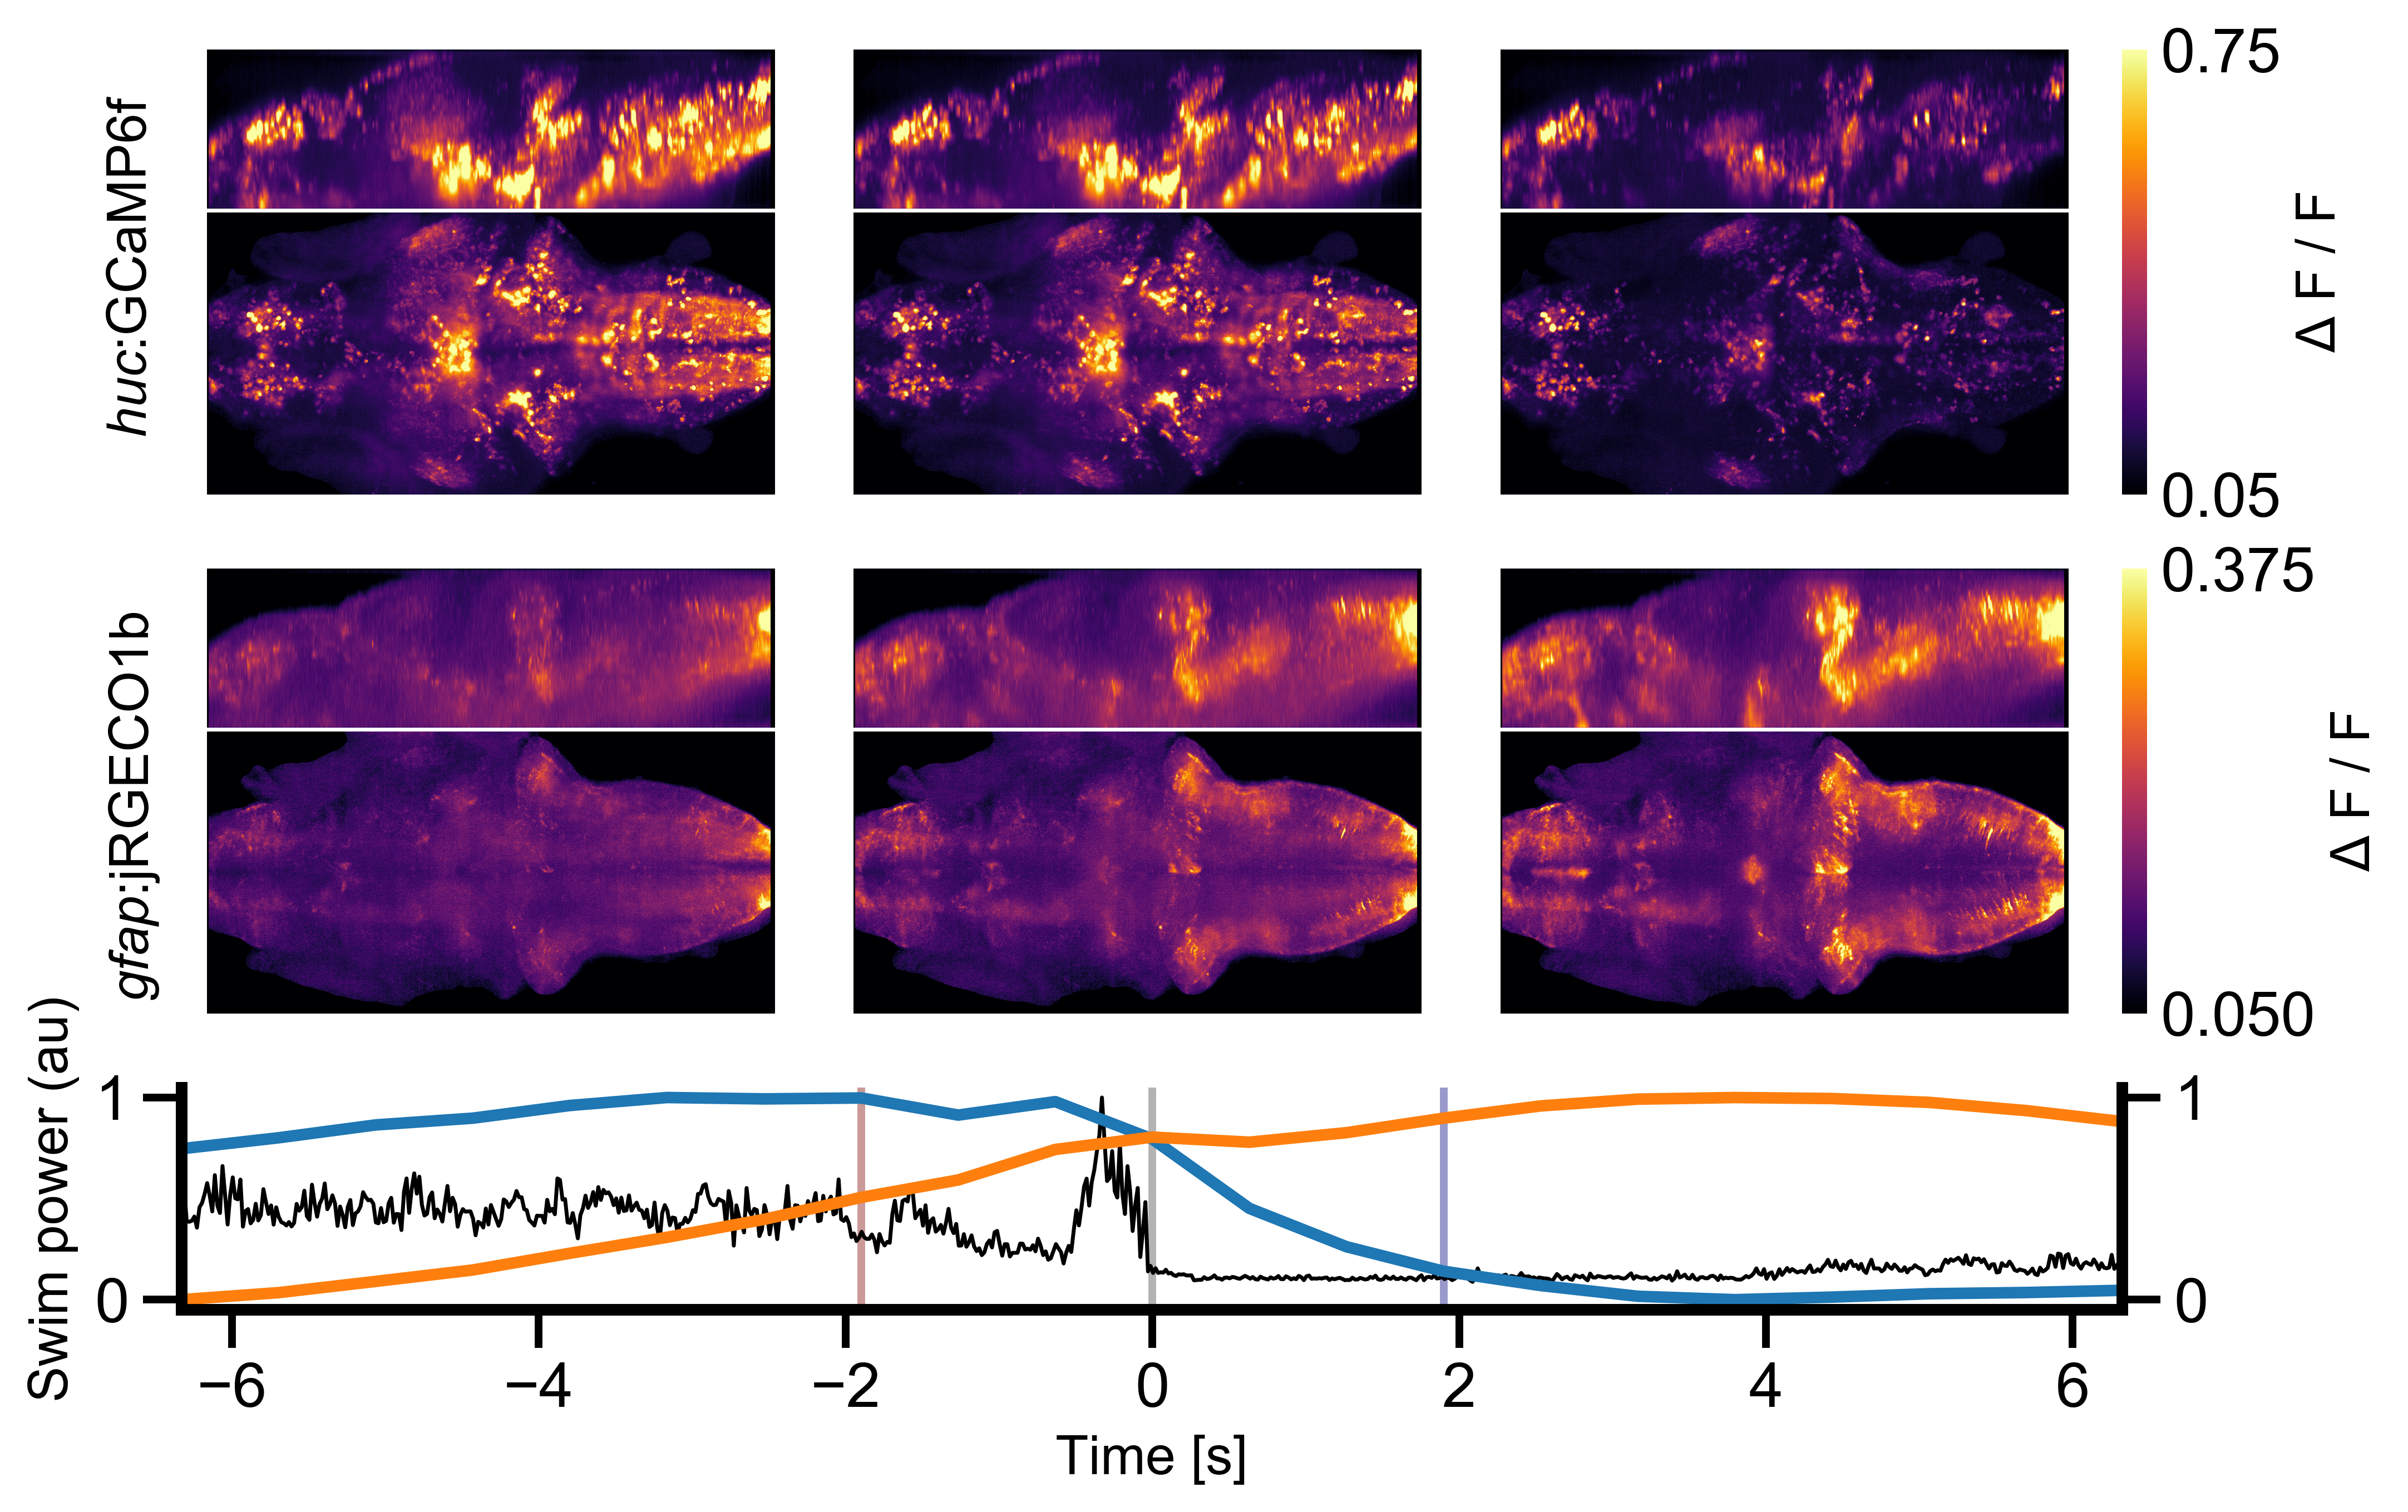

In [29]:
import matplotlib.gridspec as gridspec
fontsize = 14
to_show = [-3, 0, 3]

#to_show = [range(-3,0), range(-1,2), range(1,4)]
# decide if we are working with timepoints or timeranges

timemode=''
if hasattr(to_show[0], '__iter__'):
    timemode='ranges'    
    t_points = []
    for r_ in to_show:
        t_points.append(np.array([np.where(window_im == t)[0][0] for t in r_]))
else:
    timemode='points'
    t_points = [np.where(window_im == t)[0][0] for t in to_show]

vol = trig_gu
triggers = gu_inds

dims= vol.shape

cmap='inferno'
x_axis_im = window_im / fs_im
window_ep = np.arange(x_axis_im[0] * 6000, x_axis_im[-1] * 6000).astype('int')
ds_ep = 100
x_axis_ep = window_ep[::ds_ep] / 6000

from scipy.signal import decimate

trig_ep_gu = triggered_behavior(triggers, window_ep, swims).mean(0)
trig_ep_gu = rescale_intensity(decimate(trig_ep_gu, ds_ep, ftype='fir'), out_range=(0,1))

scale = .001

fig_ims = plt.figure(figsize=(9, 6), dpi=500)
gs = gridspec.GridSpec(3, len(t_points), height_ratios=[2, 2, 1], hspace=None, wspace=0)
axs_ims = []
axs_ims.append([plt.subplot(gs[0,t]) for t in range(len(t_points))])
axs_ims.append([plt.subplot(gs[1,t]) for t in range(len(t_points))])

axs_ts = plt.subplot(gs[-1,:])
colors = [(.8,.6,.6), (.7,.7,.7), (.6,.6,.8), (.3, .3, .3)]

# clims for the trial average
clims = dict(g=[.05, .25 * 1.5], n=[.05, .5 * 1.5])

# clims for the single-trial example
#clims = dict(g=[.05, 1], n=[.05, 1])

# rois = dict(g=(slice(0, None), slice(None, 250)), n=(slice(0, None), slice(240,490)))
rois = dict(g=(slice(0, None), slice(0, vol.shape[2]//2)), n=(slice(0, None), slice(vol.shape[2]//2, None)))
genotypes = ['n', 'g']
genotype_labels = dict(g=r'$gfap$:jRGECO1b', n=r'$huc$:GCaMP6f')

dff_label = r'$\Delta$ F / F'

# plot images
for ind, t in enumerate(t_points):        
    for ind_g, val in enumerate(genotypes):
        cur_axs = axs_ims[ind_g][ind]
        cur_axs.axis('off')
        
        if timemode == 'points':
            to_show = proj_fuse(vol[t][rois[val]], np.max, aspect=aspect)[:,:-290]
        elif timemode == 'ranges':
            to_show = proj_fuse(vol[t].max(0)[rois[val]], np.max, aspect=aspect)[:,:-290]
        
        axs_ims[ind_g][ind].imshow(to_show, cmap=cmap, clim=clims[val], origin='lower')
        # draw a white line at the boundary between the projections
        axs_ims[ind_g][ind].plot([0, to_show.shape[-1]], 2 * [vol.shape[2]//2], color='w', linewidth=1)

        if ind == 0:
            cur_axs.text(-180,650, genotype_labels[val], color='k', fontsize=fontsize, rotation=90)
           # cur_axs.set_ylabel(genotypes[val])
    
# plot corresponding timeseries
axs_ts.plot(x_axis_ep, trig_ep_gu, color='k', linewidth=1)

# plot mean of glia and neurons
twinx = axs_ts.twinx()
twinx.plot(window_im / fs_im, rescale_intensity(vol[:, :, rois['n'][1], rois['n'][0]].mean((1,2,3)), out_range=(0,1)));
twinx.plot(window_im / fs_im, rescale_intensity(vol[:, :, rois['g'][1], rois['g'][0]].mean((1,2,3)), out_range=(0,1)));
twinx.spines['right'].set_visible(True)
axs_ts.set_xlim(x_axis_ep[0], x_axis_ep[-1])
axs_ts.set_ylabel('Swim power (au)', fontsize=fontsize)
axs_ts.set_xlabel('Time [s]', fontsize=fontsize)

if timemode == 'points':
    [axs_ts.axvline(window_im[t] / fs_im, zorder=0, linewidth=2, color=colors[ind_t]) for ind_t, t in enumerate(t_points)]
elif timemode =='ranges':
    [axs_ts.axvspan(*window_im[t[[0,-1]]] / fs_im, zorder=0, color=colors[ind_t]) for ind_t, t in enumerate(t_points)]

#axs_ts.set_yticks([0,1])
axs_ts.set_xticks(range(-6, 8, 2))

for ind_g, val in enumerate(genotypes):
    b = offset_colorbar(fig_ims, axs_ims[ind_g][-1], ticks=clims[val])    
    b.ax.set_ylabel(dff_label, fontsize=fontsize, fontname='Arial')
    b.ax.tick_params(width=0)
    b.ax.tick_params(length=0)

#plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig(dirs['output'] + '{0}_triggered_average_gu.pdf'.format(exp_name), dpi=500)